In [13]:
%matplotlib inline
import networkx as nx
import re
import matplotlib.pyplot as pt
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from graphframes import *

In [14]:
sqlcontext = SQLContext(sc)

Stanford graphs
dblp.graph.large


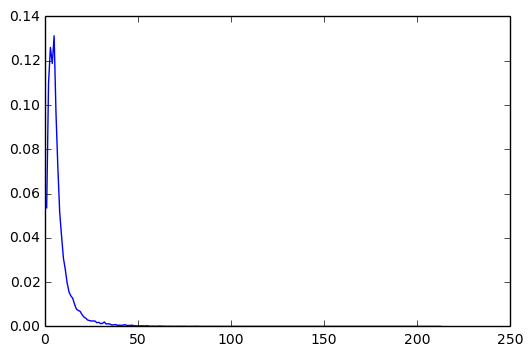

youtube.graph.large


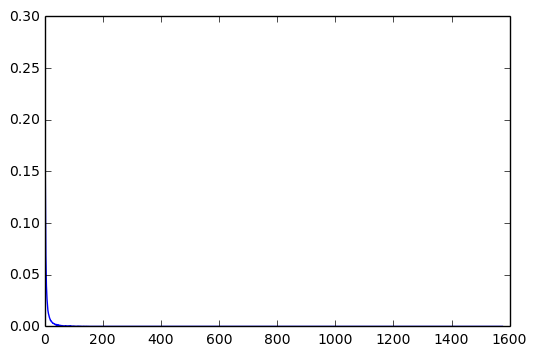

amazon.graph.small


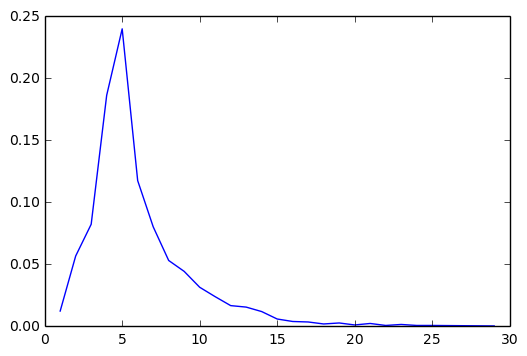

dblp.graph.small


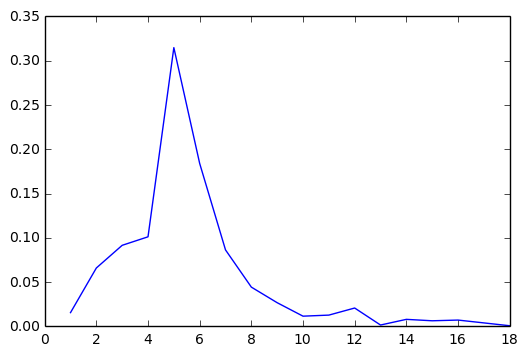

amazon.graph.large


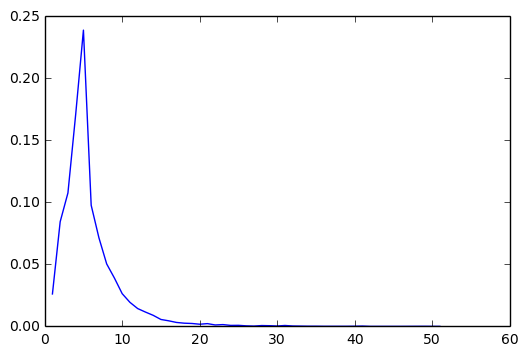

youtube.graph.small


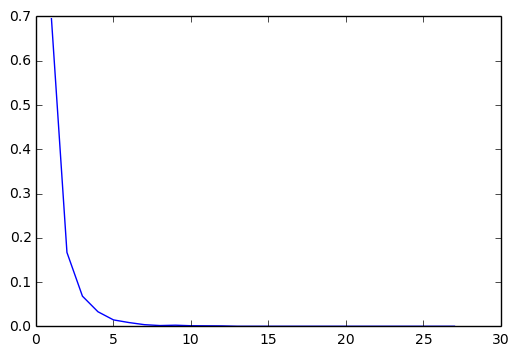

random graphs


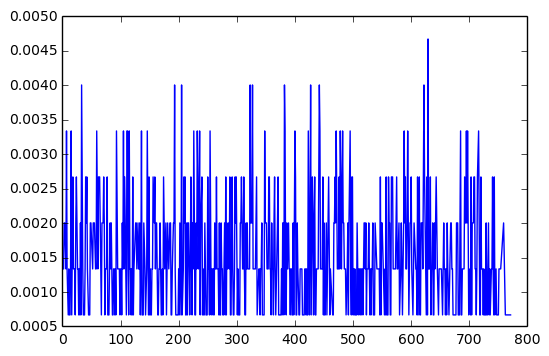

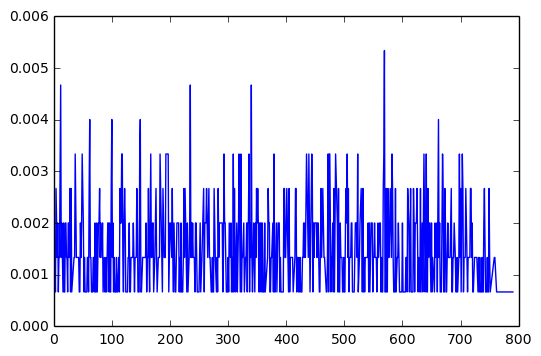

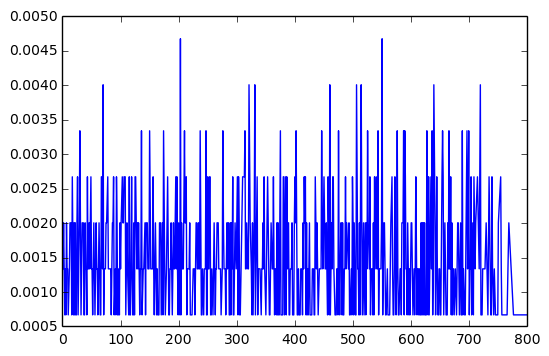

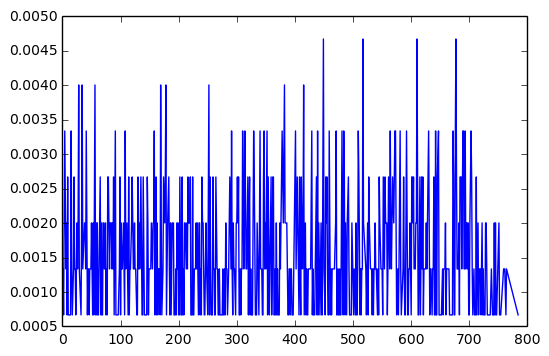

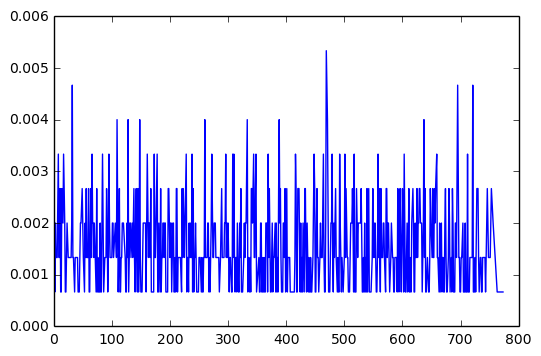

In [17]:
def degreedist(graph):
    vertexdegreeIn = graph.inDegrees
    dist = vertexdegreeIn.groupBy('inDegree').agg(count('id')).sort('inDegree')
    return dist.select(col('inDegree').alias('degree'), col('count(id)').alias('count'))

def createGraphFrame(nodesRdd, edgesRddComplete):
    nodeFrame = sqlcontext.createDataFrame(nodesRdd, ['id'])
    edgeFrame = sqlcontext.createDataFrame(edgesRddComplete, ['src', 'dst'])
    graph = GraphFrame(nodeFrame,edgeFrame)
    return graph

def getGraphFrame(filename):
    with open(filename) as f:
        content = f.readlines()
    contentRdd = sc.parallelize(content)
    nodesRdd = contentRdd.flatMap(lambda x: re.split(' |,',x.strip())).distinct().map(lambda x: (x,))
    edgesRdd = contentRdd.map(lambda x: tuple(re.split(' |,',x.strip())))
    reverseedgeRdd = contentRdd.map(lambda x: (re.split(' |,',x.strip())[1], re.split(' |,',x.strip())[0]))
    edgesRddComplete = edgesRdd.union(reverseedgeRdd)
    graph = createGraphFrame(nodesRdd,edgesRddComplete)
    return graph

def plot_distribution(dist):
    degree = dist.select('degree').flatMap(lambda x: x).collect()
    degreeCount = dist.select('count').flatMap(lambda x: x).collect()
    totalsum = 0
    for i in degreeCount:
        totalsum += i
    temp = [float(i)/totalsum for i in degreeCount]
    pt.plot(degree, temp)
    pt.show()

def main():
    path = './stanford_graphs/'
    files = os.listdir(path)
    print "Stanford graphs"
    for eachfile in files:
        graph = getGraphFrame(path+eachfile)
        dist = degreedist(graph)
        print eachfile
        plot_distribution(dist)
    
    print "random graphs"
    for i in range(5):
        ranGraph = nx.fast_gnp_random_graph(1500,0.5, seed=i, directed=False)
        nodes = [(x,) for x in ranGraph.nodes()]
        graph = createGraphFrame(nodes,ranGraph.edges())
        dist = degreedist(graph)
        plot_distribution(dist)

main()